In [ ]:
!python -c "import torch; print('CUDA Available:', torch.cuda.is_available()); print('GPU Name:', torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU')"

CUDA Available: True
GPU Name: NVIDIA GeForce RTX 2080 Ti


In [ ]:
import torch

num_gpus = torch.cuda.device_count()

print(f"Number of GPUs Available: {num_gpus}")

if num_gpus > 0:
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPUs available in the system.")


Number of GPUs Available: 1
GPU 0: NVIDIA GeForce RTX 2080 Ti


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.path import Path
from skimage.draw import polygon
from skimage.measure import find_contours

image_folder = 'E:/PW2/DB0/images'
expert1_folder = 'E:/PW2/DB0/experts_anotation'
expert2_folder = 'E:/PW2/DB0/experts_anotation'
resized_folder = 'E:/PW2/DB0/resized_images'
populated_folder = 'E:/PW2/DB0/populated_images'
mask_folder = 'E:/PW2/DB0/u_net_masks'

os.makedirs(resized_folder, exist_ok=True)
os.makedirs(populated_folder, exist_ok=True)
os.makedirs(mask_folder, exist_ok=True)

def load_coordinates(file_path):
    try:
        coords = np.genfromtxt(file_path, delimiter=',')
        if coords.ndim == 1:
            coords = coords.reshape(-1, 2)
        if coords.shape[1] != 2:
            raise ValueError(f"Invalid format in file: {file_path}")
        return coords
    except Exception as e:
        print(f"Error loading coordinates from {file_path}: {e}")
        return None

def sort_coordinates(coords):
    centroid = coords.mean(axis=0)
    angles = np.arctan2(coords[:, 1] - centroid[1], coords[:, 0] - centroid[0])
    sorted_indices = np.argsort(angles)
    sorted_coords = coords[sorted_indices]
    return np.vstack((sorted_coords, sorted_coords[0]))

image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.jpg') or f.endswith('.png')])

for image_file in image_files:
    image_number = os.path.splitext(image_file)[0][-3:]
    expert1_file = os.path.join(expert1_folder, f'annotExpert1_{image_number}.txt')
    expert2_file = os.path.join(expert2_folder, f'annotExpert2_{image_number}.txt')
    image_path = os.path.join(image_folder, image_file)
    image = Image.open(image_path).convert('RGB')
    resized_image = image.resize((512, 512))
    resized_output_path = os.path.join(resized_folder, f'resized_{image_number}.png')
    resized_image.save(resized_output_path)
    print(f'Saved resized image: {resized_output_path}')
    expert1_coords = load_coordinates(expert1_file)
    expert2_coords = load_coordinates(expert2_file)

    if expert1_coords is None or expert2_coords is None:
        print(f"Skipping image {image_number} due to invalid annotation files.")
        continue
    expert1_coords = sort_coordinates(expert1_coords)
    expert2_coords = sort_coordinates(expert2_coords)

    plt.imshow(image)
    plt.plot(expert1_coords[:, 0], expert1_coords[:, 1], 'go-', markersize=3, label='Expert 1')
    plt.plot(expert2_coords[:, 0], expert2_coords[:, 1], 'bo-', markersize=3, label='Expert 2')
    plt.legend()

    plt.axis('off')
    populated_image_path = os.path.join(populated_folder, f'populated_{image_number}.png')
    plt.savefig(populated_image_path, bbox_inches='tight', pad_inches=0)
    plt.close()

    populated_image = Image.open(populated_image_path)
    resized_populated_image = populated_image.resize((512, 512))
    resized_populated_image.save(populated_image_path)
    print(f'Saved populated and resized image: {populated_image_path}')
    def coords_to_mask(coords, shape):
        mask = np.zeros(shape, dtype=np.uint8)
        path = Path(coords)
        x, y = np.mgrid[:shape[0], :shape[1]]
        points = np.vstack((y.ravel(), x.ravel())).T
        grid = path.contains_points(points).reshape(shape)
        mask[grid] = 1
        return mask
    original_shape = image.size[::-1]
    expert1_mask = coords_to_mask(expert1_coords, original_shape)
    expert2_mask = coords_to_mask(expert2_coords, original_shape)

    intersection_mask = expert1_mask & expert2_mask

    contours = find_contours(intersection_mask, level=0.5)

    if contours:
        largest_contour = max(contours, key=lambda x: len(x))

        scale_x = 512 / original_shape[1]
        scale_y = 512 / original_shape[0]
        resized_contour = np.array([[point[1] * scale_x, point[0] * scale_y] for point in largest_contour])

        resized_mask = np.zeros((512, 512), dtype=np.uint8)
        rr, cc = polygon(resized_contour[:, 1], resized_contour[:, 0], resized_mask.shape)
        resized_mask[rr, cc] = 1
        mask_output_path = os.path.join(mask_folder, f'mask_{image_number}.png')
        Image.fromarray((resized_mask * 255).astype(np.uint8)).save(mask_output_path)
        print(f'Saved U-Net segmentation mask: {mask_output_path}')


Saved resized image: E:/PW2/DB0/resized_images\resized_001.png
Saved populated and resized image: E:/PW2/DB0/populated_images\populated_001.png
Saved U-Net segmentation mask: E:/PW2/DB0/u_net_masks\mask_001.png
Saved resized image: E:/PW2/DB0/resized_images\resized_002.png
Saved populated and resized image: E:/PW2/DB0/populated_images\populated_002.png
Saved U-Net segmentation mask: E:/PW2/DB0/u_net_masks\mask_002.png
Saved resized image: E:/PW2/DB0/resized_images\resized_003.png
Saved populated and resized image: E:/PW2/DB0/populated_images\populated_003.png
Saved U-Net segmentation mask: E:/PW2/DB0/u_net_masks\mask_003.png
Saved resized image: E:/PW2/DB0/resized_images\resized_004.png
Saved populated and resized image: E:/PW2/DB0/populated_images\populated_004.png
Saved U-Net segmentation mask: E:/PW2/DB0/u_net_masks\mask_004.png
Saved resized image: E:/PW2/DB0/resized_images\resized_005.png
Saved populated and resized image: E:/PW2/DB0/populated_images\populated_005.png
Saved U-Net 

In [ ]:
import os
from skimage.segmentation import slic, mark_boundaries
from skimage.util import img_as_float
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
resized_folder = 'E:/PW2/DB0/resized_images'
superpixel_folder = 'E:/PW2/DB0/superpixel_maps'
os.makedirs(superpixel_folder, exist_ok=True)
image_files = sorted([f for f in os.listdir(resized_folder) if f.endswith('.jpg') or f.endswith('.png')])

for image_file in image_files:
    image_path = os.path.join(resized_folder, image_file)
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)
    n_segments = 850
    compactness = 10
    superpixels = slic(image_np, n_segments=n_segments, compactness=compactness, start_label=1)

    superpixel_image = np.zeros_like(image_np)
    for seg_val in np.unique(superpixels):
        mask = superpixels == seg_val

        avg_color = np.mean(image_np[mask], axis=0)

        superpixel_image[mask] = avg_color

    superpixel_output_path = os.path.join(superpixel_folder, f'superpixel_{os.path.splitext(image_file)[0]}.png')
    superpixel_image_pil = Image.fromarray(np.uint8(superpixel_image))
    superpixel_image_pil.save(superpixel_output_path)

    print(f'Saved superpixel map: {superpixel_output_path}')


Saved superpixel map: E:/PW2/DB0/superpixel_maps\superpixel_resized_001.png
Saved superpixel map: E:/PW2/DB0/superpixel_maps\superpixel_resized_002.png
Saved superpixel map: E:/PW2/DB0/superpixel_maps\superpixel_resized_003.png
Saved superpixel map: E:/PW2/DB0/superpixel_maps\superpixel_resized_004.png
Saved superpixel map: E:/PW2/DB0/superpixel_maps\superpixel_resized_005.png
Saved superpixel map: E:/PW2/DB0/superpixel_maps\superpixel_resized_006.png
Saved superpixel map: E:/PW2/DB0/superpixel_maps\superpixel_resized_007.png
Saved superpixel map: E:/PW2/DB0/superpixel_maps\superpixel_resized_008.png
Saved superpixel map: E:/PW2/DB0/superpixel_maps\superpixel_resized_009.png
Saved superpixel map: E:/PW2/DB0/superpixel_maps\superpixel_resized_010.png
Saved superpixel map: E:/PW2/DB0/superpixel_maps\superpixel_resized_011.png
Saved superpixel map: E:/PW2/DB0/superpixel_maps\superpixel_resized_012.png
Saved superpixel map: E:/PW2/DB0/superpixel_maps\superpixel_resized_013.png
Saved superp

In [ ]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split

original_images_dir = 'E:/PW2/DB0/resized_images'
superpixel_maps_dir = 'E:/PW2/DB0/superpixel_maps'
segmentation_masks_dir = 'E:/PW2/DB0/u_net_masks'

input_size = (512, 512)
output_dir = 'E:/PW2/DB0/prepared_dataset'
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory: {output_dir}, Exists: {os.path.exists(output_dir)}")

X = []
y = []
for original_file in os.listdir(original_images_dir):
    if not original_file.startswith("resized_"):
        continue
    identifier = original_file.replace("resized_", "")
    superpixel_file = f"superpixel_resized_{identifier}"
    mask_file = f"mask_{identifier}"

    orig_path = os.path.join(original_images_dir, original_file)
    sp_path = os.path.join(superpixel_maps_dir, superpixel_file)
    mask_path = os.path.join(segmentation_masks_dir, mask_file)

    if not os.path.exists(orig_path) or not os.path.exists(sp_path) or not os.path.exists(mask_path):
        print(f"Missing files for identifier: {identifier}")
        continue

    original_image = cv2.imread(orig_path)
    if original_image is None:
        print(f"Skipping file {original_file}, as it could not be loaded.")
        continue
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    original_image = cv2.resize(original_image, input_size) / 255.0

    superpixel_map = cv2.imread(sp_path)
    if superpixel_map is None:
        print(f"Skipping file {superpixel_file}, as it could not be loaded.")
        continue
    superpixel_map = cv2.cvtColor(superpixel_map, cv2.COLOR_BGR2RGB)
    superpixel_map = cv2.resize(superpixel_map, input_size) / 255.0

    combined_input = np.concatenate((original_image, superpixel_map), axis=-1)
    X.append(combined_input)

    segmentation_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if segmentation_mask is None:
        print(f"Skipping file {mask_file}, as it could not be loaded.")
        continue
    segmentation_mask = cv2.resize(segmentation_mask, input_size) / 255.0
    y.append(segmentation_mask)

X = np.array(X)
y = np.array(y)
if len(X) == 0 or len(y) == 0:
    print("No data loaded. Check your dataset.")
else:
    print(f"Number of samples loaded: {len(X)}")
    y = np.expand_dims(y, axis=-1)

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    np.save(os.path.join(output_dir, "X_train.npy"), X_train)
    np.save(os.path.join(output_dir, "y_train.npy"), y_train)
    np.save(os.path.join(output_dir, "X_val.npy"), X_val)
    np.save(os.path.join(output_dir, "y_val.npy"), y_val)
    np.save(os.path.join(output_dir, "X_test.npy"), X_test)
    np.save(os.path.join(output_dir, "y_test.npy"), y_test)

    print("Dataset preparation and splitting completed!")


Output directory: E:/PW2/DB0/prepared_dataset, Exists: True
Number of samples loaded: 130
Dataset preparation and splitting completed!


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback

def unet_model(input_shape=(512, 512, 6)):
    inputs = Input(input_shape)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs, outputs)
    return model

class TrainingLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"\nEpoch {epoch+1}/{self.params['epochs']}")
        print(f" - Loss: {logs.get('loss'):.4f}")
        print(f" - Accuracy: {logs.get('accuracy'):.4f}")
        print(f" - Validation Loss: {logs.get('val_loss'):.4f}")
        print(f" - Validation Accuracy: {logs.get('val_accuracy'):.4f}")
        print("-" * 50)

prepared_dataset_dir = "E:/PW2/DB0/prepared_dataset"
X_train = np.load(os.path.join(prepared_dataset_dir, "X_train.npy"))
y_train = np.load(os.path.join(prepared_dataset_dir, "y_train.npy"))
X_val = np.load(os.path.join(prepared_dataset_dir, "X_val.npy"))
y_val = np.load(os.path.join(prepared_dataset_dir, "y_val.npy"))

model = unet_model()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

training_logger = TrainingLogger()

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=4, verbose=0, callbacks=[training_logger])

dir = "E:/PW2/DB0/unet/"

model_path = os.path.join(dir, "unet_model_with_superpixel.h5")
model.save(model_path)



Epoch 1/20
 - Loss: 0.4876
 - Accuracy: 0.9172
 - Validation Loss: 0.2048
 - Validation Accuracy: 0.9842
--------------------------------------------------

Epoch 2/20
 - Loss: 0.1671
 - Accuracy: 0.9851
 - Validation Loss: 0.1050
 - Validation Accuracy: 0.9842
--------------------------------------------------

Epoch 3/20
 - Loss: 0.0735
 - Accuracy: 0.9851
 - Validation Loss: 0.0727
 - Validation Accuracy: 0.9842
--------------------------------------------------

Epoch 4/20
 - Loss: 0.0594
 - Accuracy: 0.9851
 - Validation Loss: 0.0684
 - Validation Accuracy: 0.9842
--------------------------------------------------

Epoch 5/20
 - Loss: 0.0578
 - Accuracy: 0.9851
 - Validation Loss: 0.0680
 - Validation Accuracy: 0.9842
--------------------------------------------------

Epoch 6/20
 - Loss: 0.0549
 - Accuracy: 0.9851
 - Validation Loss: 0.0584
 - Validation Accuracy: 0.9842
--------------------------------------------------

Epoch 7/20
 - Loss: 0.0516
 - Accuracy: 0.9851
 - Validat


Epoch 20/20
 - Loss: 0.0381
 - Accuracy: 0.9886
 - Validation Loss: 0.0356
 - Validation Accuracy: 0.9888
--------------------------------------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


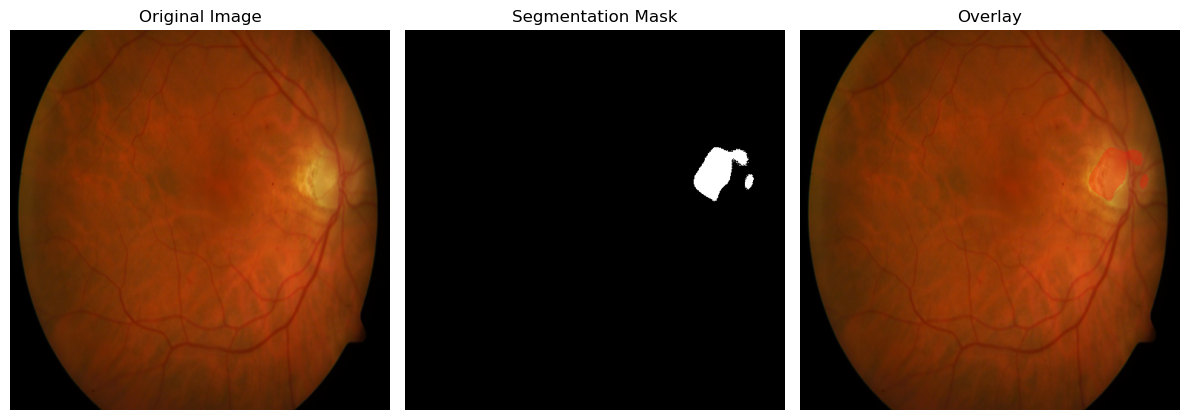

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

def preprocess_image(image_path, superpixel_path, input_size=(512, 512)):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, input_size) / 255.0
    superpixel_map = cv2.imread(superpixel_path)
    if superpixel_map is None:
        raise FileNotFoundError(f"Superpixel map not found at {superpixel_path}")
    superpixel_map = cv2.cvtColor(superpixel_map, cv2.COLOR_BGR2RGB)
    superpixel_map = cv2.resize(superpixel_map, input_size) / 255.0
    combined_input = np.concatenate((image, superpixel_map), axis=-1)
    combined_input = np.expand_dims(combined_input, axis=0)
    return combined_input

def postprocess_and_visualize(prediction, original_image_path, threshold=0.5):
    prediction = prediction[0, :, :, 0]
    prediction = (prediction > threshold).astype(np.uint8)
    original_image = cv2.imread(original_image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    original_image = cv2.resize(original_image, (prediction.shape[1], prediction.shape[0]))

    overlay = original_image.copy()
    overlay[prediction == 1] = [255, 0, 0]
    blended = cv2.addWeighted(original_image, 0.7, overlay, 0.3, 0)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Segmentation Mask")
    plt.imshow(prediction, cmap='gray')
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(blended)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

test_image_path = 'E:/PW2/DB0/resized_images/resized_069.png'
superpixel_map_path = 'E:/PW2/DB0/superpixel_maps/superpixel_resized_069.png'
model = load_model("E:/PW2/DB0/unet_model_with_superpixel.h5")

input_data = preprocess_image(test_image_path, superpixel_map_path)

prediction = model.predict(input_data)

postprocess_and_visualize(prediction, test_image_path)


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def preprocess_image(image_path, superpixel_path, input_size=(512, 512)):
    image = cv2.imread(image_path)
    superpixel_map = cv2.imread(superpixel_path)

    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    if superpixel_map is None:
        raise FileNotFoundError(f"Superpixel map not found at {superpixel_path}")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    superpixel_map = cv2.cvtColor(superpixel_map, cv2.COLOR_BGR2RGB)

    image = cv2.resize(image, input_size) / 255.0
    superpixel_map = cv2.resize(superpixel_map, input_size) / 255.0

    combined_input = np.concatenate((image, superpixel_map), axis=-1)
    combined_input = np.expand_dims(combined_input, axis=0)

    return combined_input

def load_ground_truth(image_path, input_size=(512, 512)):
    mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise FileNotFoundError(f"Mask not found at {image_path}")

    mask = cv2.resize(mask, input_size)
    mask = (mask > 127).astype(np.uint8)

    return mask

def evaluate_model(model, test_images_dir, superpixel_dir, ground_truth_dir):
    accuracy_list, precision_list, recall_list, f1_list, dice_list, iou_list = [], [], [], [], [], []

    for filename in os.listdir(test_images_dir):
        test_image_path = os.path.join(test_images_dir, filename)
        superpixel_path = os.path.join(superpixel_dir, filename.replace("resized_", "superpixel_resized_"))
        ground_truth_path = os.path.join(ground_truth_dir, filename.replace("resized_", "mask_"))

        if not os.path.exists(superpixel_path):
            print(f"❌ Superpixel map not found for {filename}, skipping...")
            continue
        if not os.path.exists(ground_truth_path):
            print(f"❌ Ground truth mask not found for {filename}, skipping...")
            continue

        input_data = preprocess_image(test_image_path, superpixel_path)
        prediction = model.predict(input_data)
        y_true = load_ground_truth(ground_truth_path)
        y_pred = (prediction[0, :, :, 0] > 0.5).astype(np.uint8)

        y_true_flat = y_true.flatten()
        y_pred_flat = y_pred.flatten()

        accuracy_list.append(accuracy_score(y_true_flat, y_pred_flat))
        precision_list.append(precision_score(y_true_flat, y_pred_flat, zero_division=1))
        recall_list.append(recall_score(y_true_flat, y_pred_flat, zero_division=1))
        f1_list.append(f1_score(y_true_flat, y_pred_flat, zero_division=1))

        intersection = np.sum(y_true_flat * y_pred_flat)
        dice_list.append((2.0 * intersection) / (np.sum(y_true_flat) + np.sum(y_pred_flat) + 1e-7))
        iou_list.append(intersection / (np.sum(y_true_flat) + np.sum(y_pred_flat) - intersection + 1e-7))

    print("\n✅ Model Evaluation Summary:")
    print(f"📌 Average Accuracy: {np.mean(accuracy_list):.4f}")
    print(f"📌 Average Precision: {np.mean(precision_list):.4f}")
    print(f"📌 Average Recall: {np.mean(recall_list):.4f}")
    print(f"📌 Average F1-Score: {np.mean(f1_list):.4f}")
    print(f"📌 Average Dice Score: {np.mean(dice_list):.4f}")
    print(f"📌 Average IoU: {np.mean(iou_list):.4f}")


model_path = "E:/PW2/DB0/unet_model_with_superpixel.h5"
test_images_dir = "E:/PW2/DB0/resized_images"
superpixel_dir = "E:/PW2/DB0/superpixel_maps"
ground_truth_dir = "E:/PW2/DB0/unet/u_net_masks"

model = load_model(model_path)
print("✅ Model loaded successfully.")

evaluate_model(model, test_images_dir, superpixel_dir, ground_truth_dir)


✅ Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step